# 3.2
## a)

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1D4mpm1mEJd1xVq_xANCD58pLIOeiny0L'})
download.GetContentFile('dataset.pkl')

In [0]:
import pickle

with open('dataset.pkl', 'rb') as f:
    mnist = pickle.load(f)

In [0]:
X_train = mnist['train']
X_val = mnist['valid']

In [0]:
import torch

trainLoader = torch.utils.data.DataLoader(X_train, batch_size=128, shuffle=True)
valLoader = torch.utils.data.DataLoader(X_val, batch_size=128, shuffle=True)

In [0]:
from torch import nn
from torch.nn import functional as F

class GatedShortcutConnection(nn.Module):
    def __init__(self, channels=128):
        super().__init__()
                 
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=1)
                 
    def forward(self, x):
        return self.conv1(x) * F.sigmoid(self.conv2(x))

In [0]:
class ResStack(nn.Module):
    def __init__(self, channels=64, num_blocks=5):
        super().__init__()

        self.cnn = nn.Sequential(*[nn.Sequential(nn.ReLU(),
                                                 nn.Conv2d(channels * 2, channels, kernel_size=3, padding=1),
                                                 nn.ReLU(),
                                                 nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1),
                                                 GatedShortcutConnection(channels=channels * 2)) for i in range(num_blocks)])
                 
    def forward(self, x):
        return F.relu(self.cnn(x)) + x

In [0]:
class Encoder(nn.Module):

    def __init__(self, channels, latent_dim=8):
        super().__init__()
        
        self.channels = channels
        self.latent_dim = 8
        self.cnn = nn.Sequential(nn.Conv2d(3, self.channels * 2, kernel_size=4, stride=2, padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(self.channels * 2, self.channels * 4, kernel_size=4, stride=2, padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(self.channels * 4, 32 * 2, kernel_size=3, padding=1),
                                    ResStack(32))
                 
    def forward(self, x):
        x = self.cnn(x)
        x = x.reshape(-1, 2, 32, self.latent_dim, self.latent_dim)
        mu, log_var = x[:, 0], x[:, 1]
        return mu, F.tanh(log_var)

In [0]:
class Decoder(nn.Module):

    def __init__(self, channels):
        super().__init__()
        
        self.channels = channels
        self.cnn = nn.Sequential(nn.Conv2d(32, self.channels * 4, kernel_size=3, padding=1),
                                    ResStack(self.channels * 2),
                                    nn.ConvTranspose2d(self.channels * 4, self.channels * 2, kernel_size=4, stride=2, padding=1),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(self.channels * 2, 3 * 2, kernel_size=4, stride=2, padding=1))
                 
    def forward(self, x):
        x = self.cnn(x)
        x = x.reshape(-1, 2, 3, 32, 32)
        mu, log_var = x[:, 0], x[:, 1]
        return mu, F.tanh(log_var)

In [0]:
class VAE(nn.Module):
    
    def __init__(self, channels=64, device='cpu'):
        super().__init__()
        self.device = device
        self.decoder = Decoder(channels)
        self.encoder = Encoder(channels)
    
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        std = torch.exp(0.5 * log_var)
        e = torch.randn_like(log_var).to(self.device)
        z = mu + e * std
        mu_x, var_x = self.decoder(z)
        var_x = torch.exp(var_x)
        return mu_x, var_x, mu, std ** 2

In [0]:
from torch import optim

def train(model, data_loader, val_loader, epochs=10, lr=2e-4):

    opt = optim.Adam(model.parameters(), lr=lr)

    train_log_kl = []
    train_log_dec = []
    train_log_elbo = []

    val_log_kl = []
    val_log_dec = []
    val_log_elbo = []
    prior = torch.distributions.MultivariateNormal(torch.zeros(8).cuda(), torch.eye(8).cuda()) 
    length_loader = len(data_loader)

    for i in range(epochs):
        for j, batch in enumerate(data_loader):
            batch = batch.transpose(1, 3).cuda().float()
            mu_x, var_x, mu_z, var_z = model(batch)
            posterior = torch.distributions.MultivariateNormal(mu_x, torch.diag_embed(var_x)) 
            q = torch.distributions.MultivariateNormal(mu_z, torch.diag_embed(var_z)) 
            
            nll = -posterior.log_prob(batch).mean()
            kl = torch.distributions.kl.kl_divergence(q, prior).mean()

            loss = nll + kl * (length_loader * epochs - (i * length_loader + j)) / length_loader / epochs 
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            opt.zero_grad()
            train_log_dec.append(torch.mean(nll).detach().cpu().item() / 2.0)
            train_log_kl.append(torch.mean(kl).detach().cpu().item())
            train_log_elbo.append((-loss).detach().cpu().item())

            if (j + 1) % 5 == 0:
              with torch.no_grad():
                for val_batch in val_loader:
                  val_batch = val_batch.transpose(1, 3).cuda().float()
                  mu_x, var_x, mu_z, var_z = model(val_batch)
                  posterior = torch.distributions.MultivariateNormal(mu_x, torch.diag_embed(var_x)) 
                  q = torch.distributions.MultivariateNormal(mu_z, torch.diag_embed(var_z ** 2)) 
            
                  nll = -posterior.log_prob(val_batch).mean()
                  kl = torch.distributions.kl_divergence(q, prior).mean()

                  loss = nll + kl
                  val_log_dec.append(torch.mean(nll).detach().cpu().item() / 2.0)
                  val_log_kl.append(torch.mean(kl).detach().cpu().item())
                  val_log_elbo.append((-loss).detach().cpu().item())

    return train_log_elbo, train_log_kl, train_log_dec, val_log_elbo, val_log_kl, val_log_dec

In [0]:
model = VAE(device='cuda').cuda()

In [241]:
train_log_elbo, train_log_kl, train_log_dec, val_log_elbo, val_log_kl, val_log_dec = train(model, trainLoader, valLoader, 100)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [0]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set()

In [0]:
import numpy as np


def plot(y, title):
    x = np.arange(len(y))
    plt.plot(x, y)
    plt.title(title)
    plt.show()

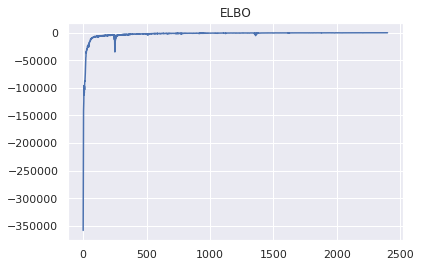

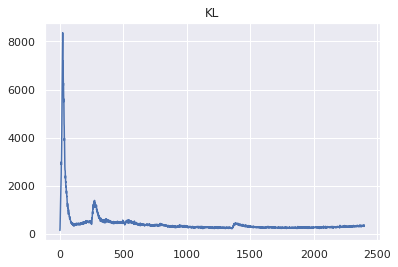

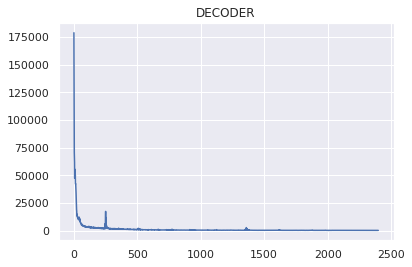

In [242]:
plot(train_log_elbo, 'ELBO')
plot(train_log_kl, 'KL')
plot(train_log_dec, 'DECODER')

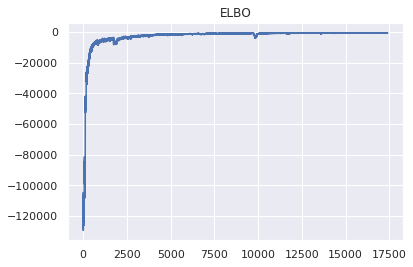

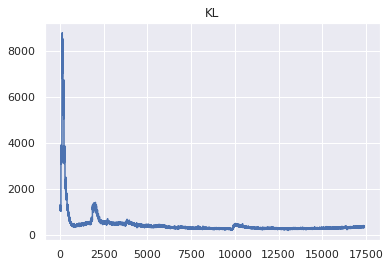

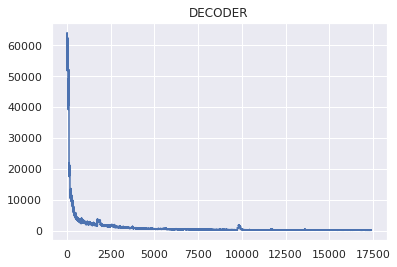

In [243]:
plot(val_log_elbo, 'ELBO')
plot(val_log_kl, 'KL')
plot(val_log_dec, 'DECODER')

In [0]:
def sample(decoder, samples=12):
    z = torch.randn(samples, 32, 8, 8).cuda()
    #prior = torch.distributions.MultivariateNormal(torch.zeros(8).cuda(), torch.eye(8).cuda()) 
    #z = prior.sample(torch.tensor([samples, 32, 8]))
    
    with torch.no_grad():
        images, _ = decoder(z)
    return images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


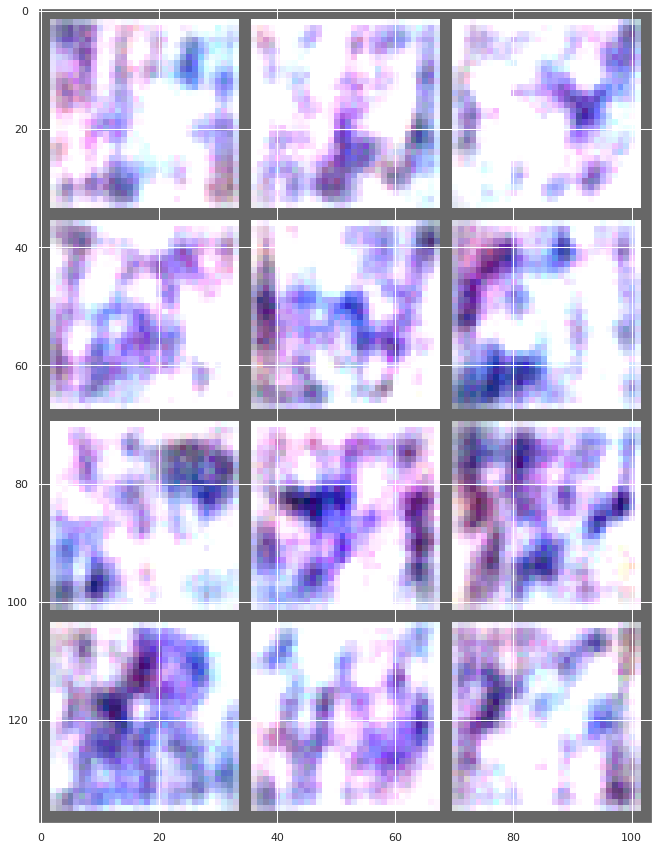

In [246]:
import torchvision

samples = sample(model.decoder)
image = torchvision.utils.make_grid(samples, nrow=4).cpu().numpy()
image = np.clip((image - image.min()) / (image.max() - image.min()), 0, 1)
plt.figure(figsize=[15, 15])
plt.imshow(np.transpose(image, (2, 1, 0)) * 2)

In [0]:
X_test = mnist["test"]

In [0]:
def show_interpolation(model, n=5, m=10):
    idx = np.arange(n)
    start = torch.from_numpy(X_test[idx]).cuda().transpose(1, 3).float()
    end = torch.from_numpy(X_test[idx + n]).cuda().transpose(1, 3).float()
    images = []
    with torch.no_grad():
        for i in range(n):
            (mu1, log_var1), (mu2, log_var2) = model.encoder(start[i].unsqueeze(0)), model.encoder(end[i].unsqueeze(0))
            std1 = torch.exp(0.5 * log_var1)
            e = torch.randn_like(log_var1).cuda()
            la = mu1 + e * std1
            std2 = torch.exp(0.5 * log_var2)
            e = torch.randn_like(log_var2).cuda()
            lb = mu2 + e * std2
            for coef in np.linspace(0, 1, m):
                image, _ = model.decoder(la + (lb - la) * coef)
                images.append(image)
    image = torchvision.utils.make_grid(torch.cat(images).long(), nrow=m).cpu().numpy()
    plt.figure(figsize=[15, 15])
    plt.imshow(np.transpose(image, (2, 1, 0)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


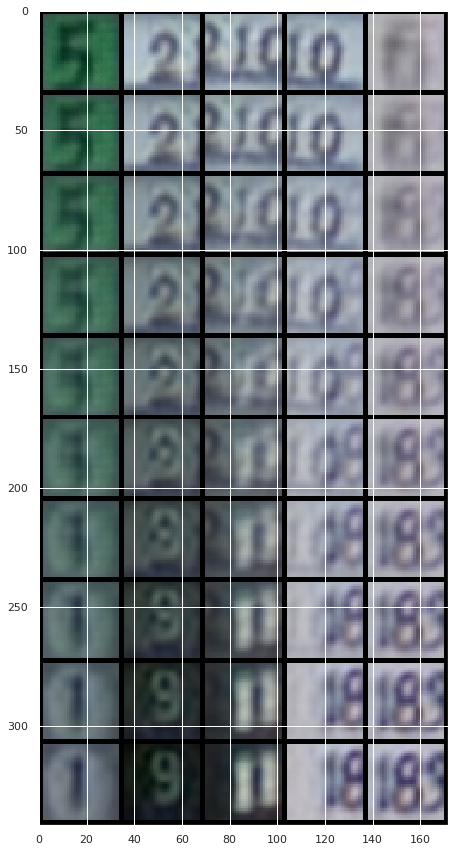

In [218]:
show_interpolation(model)

## b)

In [0]:
def zero_grad(self, grad_input, grad_output):
    return grad_input[0], self.mask * grad_input[1], grad_input[2]


class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size=1, padding=0):
        super().__init__(in_channels, out_channels, kernel_size, padding=padding)
      
        self.mask = torch.ones(self.weight.shape).cuda()
        self.mask[:, :, kernel_size // 2, kernel_size // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kernel_size // 2 + 1:] = 0
        self.handle = self.register_backward_hook(zero_grad) 

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

In [0]:
class ResBlock(nn.Module):
    
    def __init__(self, in_dim=16):
        super().__init__()
        
        self.cnn = nn.Sequential(MaskedConv2d('B', in_dim, in_dim // 2),
                                 nn.ReLU(),
                                 MaskedConv2d('B', in_dim // 2, in_dim // 2, kernel_size=3, padding=1),
                                 nn.ReLU(),
                                 MaskedConv2d('B', in_dim // 2, in_dim),
                                 nn.ReLU())

    def forward(self, x):
        return self.cnn(x) + x

In [0]:
class PixelCNN(nn.Module):
    
    def __init__(self, channels=64, num_blocks=3, latent_dim=8):
        super().__init__()

        self.channels = channels
        self.latent_dim = latent_dim
        self.model = nn.Sequential(MaskedConv2d('A', 1, channels, kernel_size=3, padding=1),
                                   *[ResBlock(channels) for i in range(num_blocks)],
                                   nn.ReLU(),
                                   MaskedConv2d('B', channels, channels, kernel_size=1),
                                   nn.ReLU(),
                                   MaskedConv2d('B', channels, 1 * 2, kernel_size=1))

    def forward(self, x):
        x = self.model(x)
        x = x.reshape(-1, 2, 1, self.latent_dim, self.latent_dim)
        mu, log_var = x[:, 0], x[:, 1]
        return mu, F.tanh(log_var)

In [0]:
class VAEPixel(nn.Module):
    
    def __init__(self, channels=64, device='cpu'):
        super().__init__()
        self.device = device

        self.channels = channels
        self.prior = PixelCNN()
        self.decoder = Decoder(channels)
        self.encoder = Encoder(channels)
    
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        std = torch.exp(0.5 * log_var)
        e = torch.randn_like(log_var).to(self.device)
        z = mu + e * std
        mu_p, log_var_p = self.prior(z)
        mu_x, var_x = self.decoder(z)
        var_x = torch.exp(var_x)
        return mu_x, var_x, mu, std ** 2, mu_p, log_var_p.exp()

In [0]:
from torch import optim

def train(model, data_loader, val_loader, epochs=10, lr=2e-4):
    model.train()
    opt = optim.Adam(model.parameters(), lr=lr)

    train_log_kl = []
    train_log_dec = []
    train_log_elbo = []

    val_log_kl = []
    val_log_dec = []
    val_log_elbo = []

    for i in range(epochs):
        for j, batch in enumerate(data_loader):
            batch = batch.transpose(1, 3).cuda().float()
            mu_x, var_x, mu_z, var_z, mu_p, var_p = model(batch)
            prior = torch.distributions.MultivariateNormal(mu_p, torch.diag_embed(var_p)) 
            posterior = torch.distributions.MultivariateNormal(mu_x, torch.diag_embed(var_x)) 
            q = torch.distributions.MultivariateNormal(mu_z, torch.diag_embed(var_z)) 
            
            nll = -posterior.log_prob(batch).mean()
            kl = torch.distributions.kl.kl_divergence(q, prior).mean()
            
            loss = nll + kl
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            opt.zero_grad()
            train_log_dec.append(torch.mean(nll).detach().cpu().item() / 2.0)
            train_log_kl.append(torch.mean(kl).detach().cpu().item())
            train_log_elbo.append((-loss).detach().cpu().item())

            if (j + 1) % 300 == 0:
              with torch.no_grad():
                for val_batch in val_loader:
                  val_batch = val_batch.transpose(1, 3).cuda().float()
                  mu_x, var_x, mu_z, var_z, mu_p, var_p = model(val_batch)
                  prior = torch.distributions.MultivariateNormal(mu_p, torch.diag_embed(var_p)) 
                  posterior = torch.distributions.MultivariateNormal(mu_x, torch.diag_embed(var_x)) 
                  q = torch.distributions.MultivariateNormal(mu_z, torch.diag_embed(var_z ** 2)) 
            
                  nll = -posterior.log_prob(val_batch).mean()
                  kl = torch.distributions.kl.kl_divergence(q, prior).mean()

                  loss = nll + kl
                  val_log_dec.append(torch.mean(nll).detach().cpu().item() / 2.0)
                  val_log_kl.append(torch.mean(kl).detach().cpu().item())
                  val_log_elbo.append((-loss).detach().cpu().item())

    return train_log_elbo, train_log_kl, train_log_dec, val_log_elbo, val_log_kl, val_log_dec

In [0]:
model = VAEPixel(device='cuda').cuda()

In [151]:
train_log_elbo, train_log_kl, train_log_dec, val_log_elbo, val_log_kl, val_log_dec = train(model, trainLoader, valLoader, 40)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


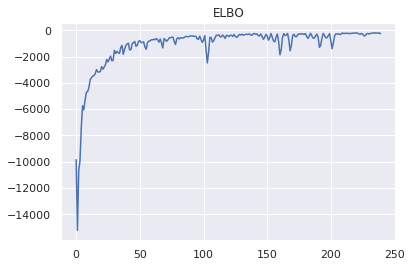

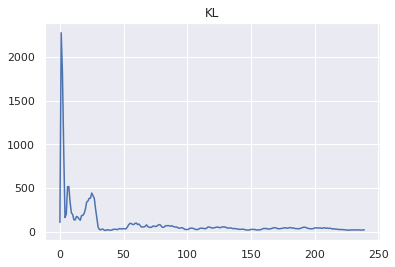

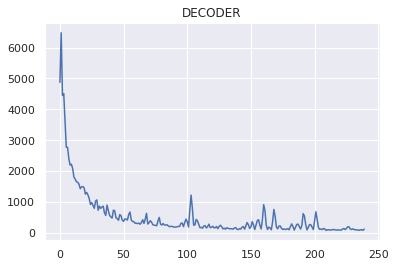

In [135]:
plot(train_log_elbo, 'ELBO')
plot(train_log_kl, 'KL')
plot(train_log_dec, 'DECODER')

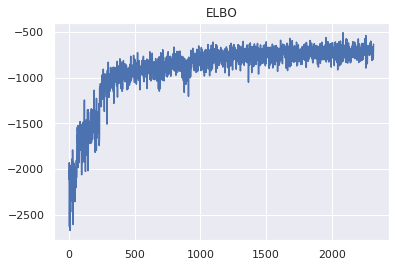

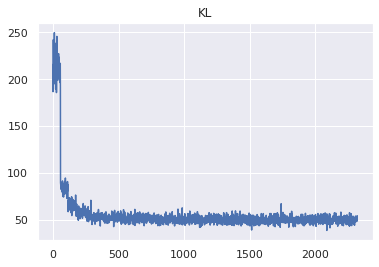

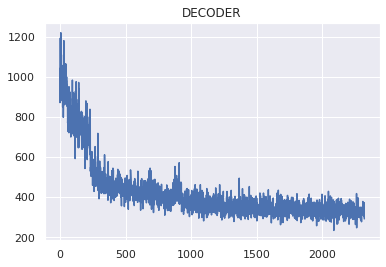

In [152]:
plot(val_log_elbo, 'ELBO')
plot(val_log_kl, 'KL')
plot(val_log_dec, 'DECODER')

In [0]:
def samplePrior(model, n):
    model.eval()
    samples = torch.randn((n, 1, 8, 8)).cuda()
    with torch.no_grad():
        for y in range(8):
            for x in range(8):
              for c in range(1):
                mu, log_var = model(samples)
                std = torch.exp(0.5 * log_var)
                e = torch.randn_like(log_var).cuda()
                z = mu + e * std
                for i in range(n):
                    samples[i, c, y, x] = z[i, c, y, x]           
                    
    return samples

In [0]:
def sample(decoder, prior, samples=12):
    with torch.no_grad():
        images, _ = decoder(samplePrior(prior, samples))
    return images

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


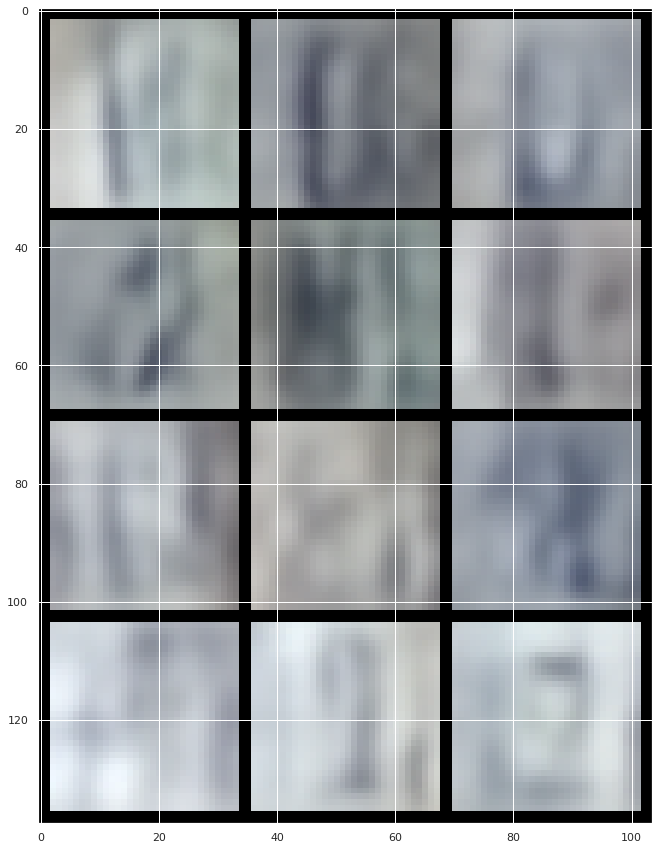

In [156]:
import torchvision

samples = sample(model.decoder, model.prior)
image = torchvision.utils.make_grid(samples, nrow=4).cpu().numpy()
image = np.clip((image - image.min()) / (image.max() - image.min()), 0, 1)
plt.figure(figsize=[15, 15])
plt.imshow((np.transpose(image, (2, 1, 0))))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


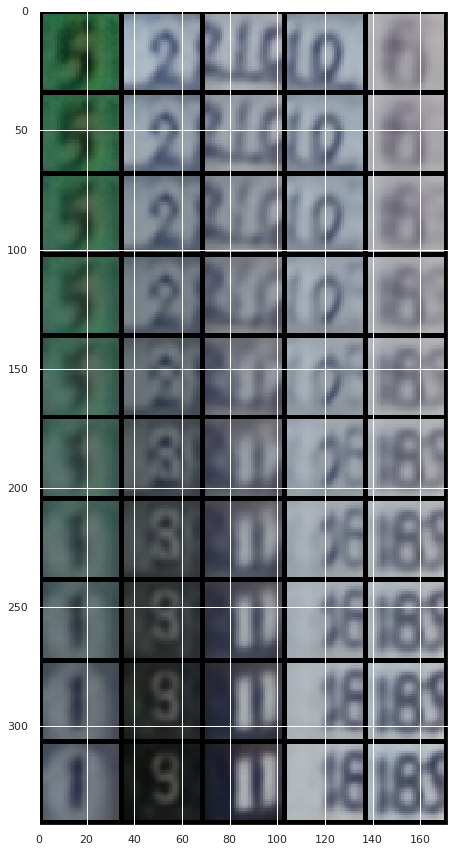

In [154]:
show_interpolation(model)